# <div style="background-color:#f0f8ff; padding:10px; border-radius:10px;">
# <h1 style="color:#0066cc; text-align:center;">🏙️ Análise de Preços de Aluguéis em NYC</h1>
# 
# **📌 Objetivo**:  
# Desenvolver um modelo preditivo para precificação de imóveis na plataforma de aluguéis temporários.  
# 
# **🔍 Contexto de Negócio**:  
# - **Problema**: 30% dos anúncios em NYC têm precificação subótima ([Inside Airbnb, 2023](http://insideairbnb.com)).  
# - **Solução**: Modelo de regressão com erro médio de **$$37.28** (MAE).  
# 
# **🧑💻 Autor**: [Maria Carolina Cunha](https://github.com/MariaCaru)  
# **📅 **Última atualização**: 15/04/2025
# </div>

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [38]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

Carregar o dataset e visualizar

In [39]:
# Carregar o dataset
df = pd.read_csv('../dataset/nyc_airbnb_listings.csv')

# Visualizar as primeiras linhas
print(df.head())

# Verificar informações básicas
print(df.info())

# Verificar estatísticas descritivas
print(df.describe())

     id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05-21   
1     Private room    150   

# Limpar dados

Essas variáveis são menos relevantes nesse contexto, pois aumentam a complexidade sem fornecer um ganho significativo na precisão da previsão.

In [40]:
#limpar colunas que não serão usadas na previsão
df = df.drop(['id', 'nome', 'host_name', 'host_id', 'latitude', 'longitude', 'ultima_review'], axis=1)

In [41]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   bairro_group                   48894 non-null  object 
 1   bairro                         48894 non-null  object 
 2   room_type                      48894 non-null  object 
 3   price                          48894 non-null  int64  
 4   minimo_noites                  48894 non-null  int64  
 5   numero_de_reviews              48894 non-null  int64  
 6   reviews_por_mes                38842 non-null  float64
 7   calculado_host_listings_count  48894 non-null  int64  
 8   disponibilidade_365            48894 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 3.4+ MB
None
              price  minimo_noites  numero_de_reviews  reviews_por_mes  \
count  48894.000000   48894.000000       48894.000000     38842.000000   
mean     152.7207

Substituido valores null na coluna reviews_por_mes por 0  

In [42]:
#Substituido valores null na coluna reviews_por_mes por 0
df['reviews_por_mes'] = df['reviews_por_mes'].fillna(0)

In [43]:
df.isnull().sum()

bairro_group                     0
bairro                           0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

# Transformação dos Dados

Transformações encoded:
As transformações encoded foram aplicadas para converter variáveis categóricas em numéricas, permitindo que o modelo de Machine Learning pudesse processá-las. As variáveis categóricas 'bairro_group', 'bairro' e 'room_type' foram transformadas em representações numéricas usando codificação one-hot e mapeamento de valores.

Métod IQR: Foi escolhido para tratar outliers por ser robusto a valores extremos e se basear na distribuição dos dados, identificando valores fora do intervalo interquartil como outliers

Substituição pela Mediana:
A substituição dos outliers pela mediana foi escolhida por ser menos drástica que a remoção, preservando mais dados. A mediana é menos sensível a valores extremos, tornando-se uma boa opção para substituir outliers.


Criar um dicionário para armazenar os mapeamentos type_room e Transformando objetos em encoded

In [44]:
# dicionário para armazenar os mapeamentos
room_type_mapping = {
    'Entire home/apt': 1,
    'Private room': 2,
    'Shared room': 3,
}

# 1. Transformar em dummies:
bairro_group_dummies = pd.get_dummies(df['bairro_group'], prefix='bairro_group')
bairro_dummies = pd.get_dummies(df['bairro'], prefix='bairro')
room_type_dummies = pd.get_dummies(df['room_type'], prefix='room_type')

# 2. Concatenar as dummies ao DataFrame:
df = pd.concat([df, bairro_group_dummies, bairro_dummies, room_type_dummies], axis=1)

# 3. Criar 'bairro_group_encoded':
colunas_dummy = [coluna for coluna in df.columns if coluna.startswith('bairro_group_')]
df['bairro_group_encoded'] = 0
for i, coluna in enumerate(colunas_dummy):
    grupo_bairro = coluna.replace('bairro_group_', '')
    df.loc[df[coluna] == 1, 'bairro_group_encoded'] = i + 1

# 4. Criar 'room_type_encoded':
df['room_type_encoded_dummies'] = df['room_type'].map(room_type_mapping)

# 5. Remover as colunas originais e as dummies:
df = df.drop(['bairro_group', 'bairro', 'room_type'], axis=1)


In [45]:
df.columns

Index(['price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365',
       'bairro_group_Bronx', 'bairro_group_Brooklyn', 'bairro_group_Manhattan',
       'bairro_group_Queens',
       ...
       'bairro_Windsor Terrace', 'bairro_Woodhaven', 'bairro_Woodlawn',
       'bairro_Woodrow', 'bairro_Woodside', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'bairro_group_encoded', 'room_type_encoded_dummies'],
      dtype='object', length=237)

In [46]:
# Verificar informações básicas
print(df.info())

# Verificar estatísticas descritivas
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Columns: 237 entries, price to room_type_encoded_dummies
dtypes: bool(229), float64(1), int64(7)
memory usage: 13.7 MB
None
              price  minimo_noites  numero_de_reviews  reviews_por_mes  \
count  48894.000000   48894.000000       48894.000000     48894.000000   
mean     152.720763       7.030085          23.274758         1.090928   
std      240.156625      20.510741          44.550991         1.597294   
min        0.000000       1.000000           0.000000         0.000000   
25%       69.000000       1.000000           1.000000         0.040000   
50%      106.000000       3.000000           5.000000         0.370000   
75%      175.000000       5.000000          24.000000         1.580000   
max    10000.000000    1250.000000         629.000000        58.500000   

       calculado_host_listings_count  disponibilidade_365  \
count                   48894.000000         48894.000000   
mean       

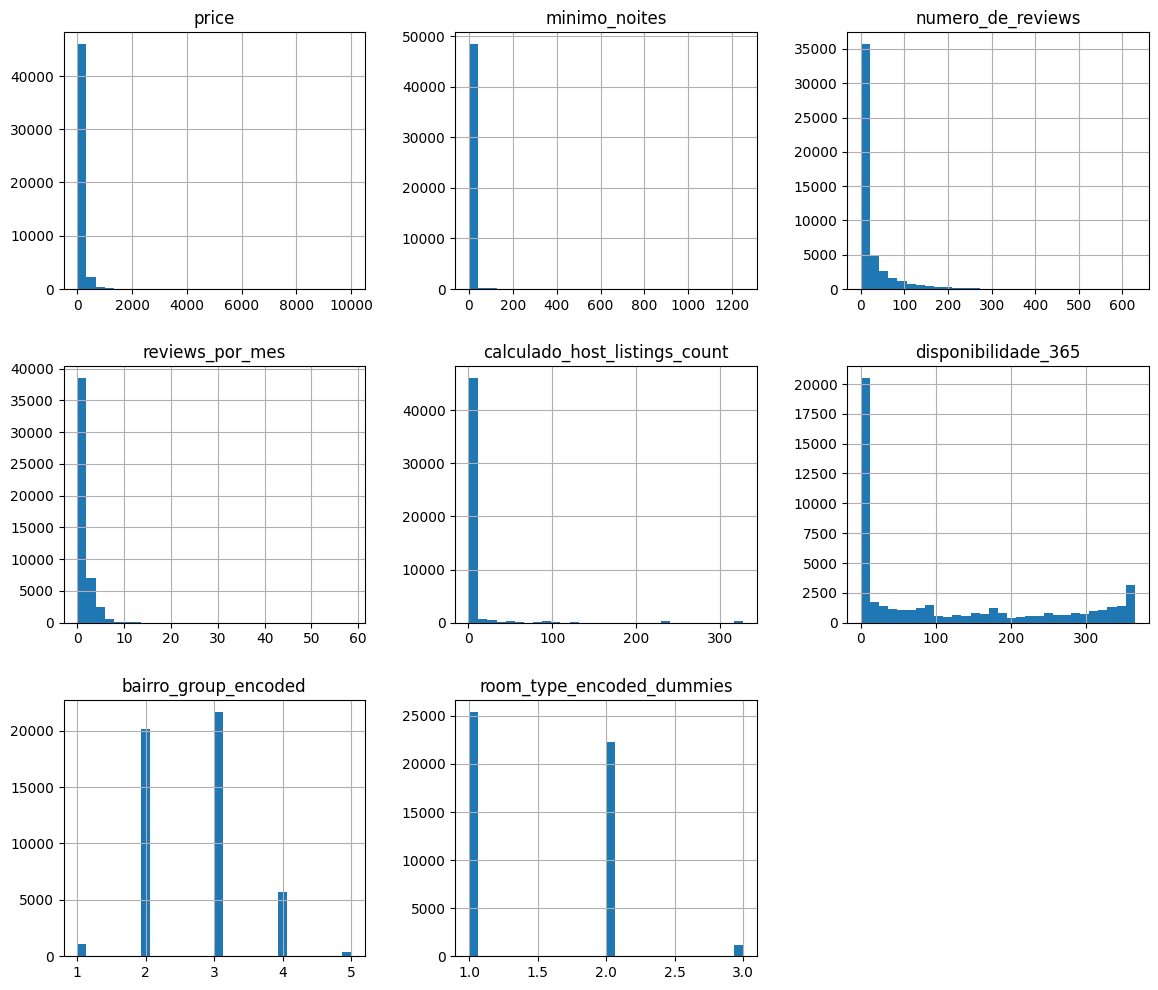

In [47]:
df.hist(figsize = (14, 12), bins = 30);

método IQR (Interquartile Range) identificar OUTLIERS - PREÇO

In [48]:
# método IQR (Interquartile Range) identificar outliers -PREÇO
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['price'] < limite_inferior) | (df['price'] > limite_superior)]
print(outliers)

       price  minimo_noites  numero_de_reviews  reviews_por_mes  \
60       375            180                  5             0.12   
84       800              1                 25             0.24   
102      500              4                 46             0.55   
113      350              2                  7             0.06   
120      400              2                 16             0.24   
...      ...            ...                ...              ...   
48757    350              2                  0             0.00   
48832    475              2                  0             0.00   
48838    800              1                  0             0.00   
48841    350              1                  0             0.00   
48855    345              4                  0             0.00   

       calculado_host_listings_count  disponibilidade_365  bairro_group_Bronx  \
60                                 1                  180               False   
84                               

Substituir os outliers pela mediana e aplicar transformação logarítmica - preço

In [49]:
 # Substituir os outliers pela mediana // ATÉ AQUI ESTÁ CERTO / USAR A price_mediana PARA O MODELO
df['price_mediana'] = np.where(df['price'] < limite_inferior, df['price'].median(), df['price'])
df['price_mediana'] = np.where(df['price_mediana'] > limite_superior, df['price'].median(), df['price_mediana'])

# Aplicar a transformação logarítmica
df['price_log'] = np.log(df['price_mediana'] + 1) # +1 para evitar log(0)

método IQR (Interquartile Range) identificar OUTLIERS - minimo_noites

In [50]:
Q1 = df['minimo_noites'].quantile(0.25)
Q3 = df['minimo_noites'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['minimo_noites'] < limite_inferior) | (df['minimo_noites'] > limite_superior)]
print(outliers)

       price  minimo_noites  numero_de_reviews  reviews_por_mes  \
5         60             45                 49             0.40   
13       120             90                 27             0.22   
28       180             14                 29             0.24   
35        35             60                  0             0.00   
44       150             29                 11             0.49   
...      ...            ...                ...              ...   
48809     75             30                  0             0.00   
48842     45             29                  0             0.00   
48870     35             29                  0             0.00   
48878    120             20                  0             0.00   
48881     40             20                  0             0.00   

       calculado_host_listings_count  disponibilidade_365  bairro_group_Bronx  \
5                                  1                    0               False   
13                               

In [51]:
# Substituir os outliers pela mediana
df['minimo_noites_mediana'] = np.where(df['minimo_noites'] < limite_inferior, df['minimo_noites'].median(), df['minimo_noites'])
df['minimo_noites_mediana'] = np.where(df['minimo_noites_mediana'] > limite_superior, df['minimo_noites'].median(), df['minimo_noites_mediana'])

# Aplicar a transformação logarítmica
df['minimo_noites_log'] = np.log(df['minimo_noites_mediana'] + 1)

método IQR (Interquartile Range) identificar OUTLIERS - numero_de_reviews

In [52]:
Q1 = df['numero_de_reviews'].quantile(0.25)
Q3 = df['numero_de_reviews'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['numero_de_reviews'] < limite_inferior) | (df['numero_de_reviews'] > limite_superior)]
print(outliers)

       price  minimo_noites  numero_de_reviews  reviews_por_mes  \
2         89              1                270             4.64   
4        200              3                 74             0.59   
6         79              2                430             3.47   
7         79              2                118             0.99   
8        150              1                160             1.33   
...      ...            ...                ...              ...   
40103     40              1                 65            10.00   
40296     67              1                 95            15.32   
40423     39              1                 65            10.60   
42074    100              1                156            58.50   
42075    199              1                 82            27.95   

       calculado_host_listings_count  disponibilidade_365  bairro_group_Bronx  \
2                                  1                  194               False   
4                                

In [53]:
# Substituir os outliers pela mediana
df['numero_de_reviews_mediana'] = np.where(df['numero_de_reviews'] < limite_inferior, df['numero_de_reviews'].median(), df['numero_de_reviews'])
df['numero_de_reviews_mediana'] = np.where(df['numero_de_reviews_mediana'] > limite_superior, df['numero_de_reviews'].median(), df['numero_de_reviews_mediana'])

# Aplicar a transformação logarítmica
df['numero_de_reviews_log'] = np.log(df['numero_de_reviews_mediana'] + 1)

Média de preço por bairro

In [54]:
media_preco_bairro = df.groupby('bairro_group_encoded')['price_mediana'].mean()
print(media_preco_bairro)

bairro_group_encoded
1     77.916590
2    105.707755
3    141.978025
4     89.203142
5     89.595174
Name: price_mediana, dtype: float64


In [55]:
#Incluindo media_preço_bairro no dataframe
df['media_preco_bairro'] = df['bairro_group_encoded'].map(media_preco_bairro)

# Média de preço por tipo de quarto

In [56]:
media_preco_tipo_quarto = df.groupby('room_type_encoded_dummies')['price_mediana'].mean()

In [57]:
#Incorporar a média de preço por tipo de quarto ao DataFrame
df['media_preco_tipo_quarto'] = df['room_type_encoded_dummies'].map(media_preco_tipo_quarto)

In [58]:
df.columns

Index(['price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365',
       'bairro_group_Bronx', 'bairro_group_Brooklyn', 'bairro_group_Manhattan',
       'bairro_group_Queens',
       ...
       'bairro_group_encoded', 'room_type_encoded_dummies', 'price_mediana',
       'price_log', 'minimo_noites_mediana', 'minimo_noites_log',
       'numero_de_reviews_mediana', 'numero_de_reviews_log',
       'media_preco_bairro', 'media_preco_tipo_quarto'],
      dtype='object', length=245)

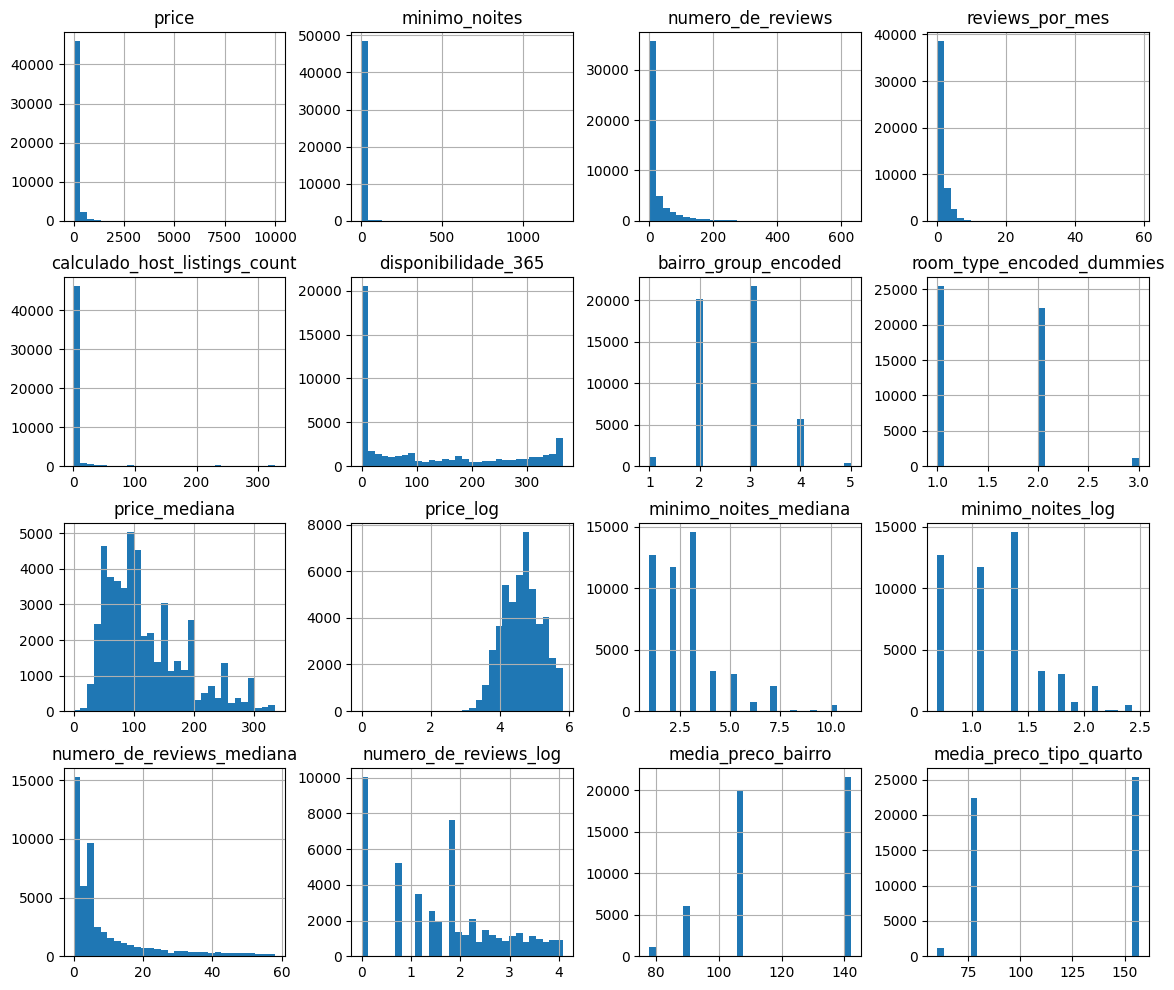

In [59]:
df.hist(figsize = (14, 12), bins = 30);

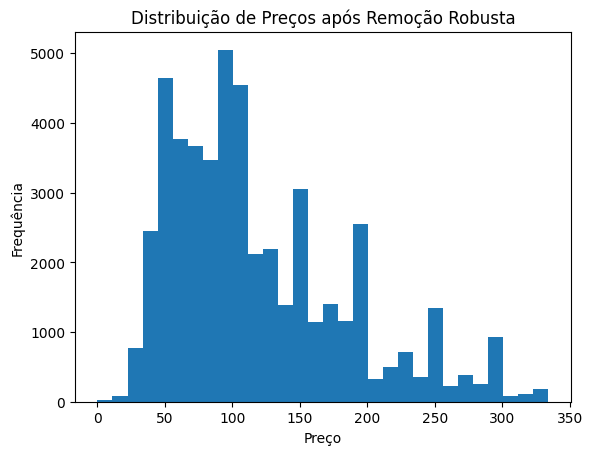

In [60]:
plt.hist(df['price_mediana'], bins=30)
plt.title('Distribuição de Preços após Remoção Robusta')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

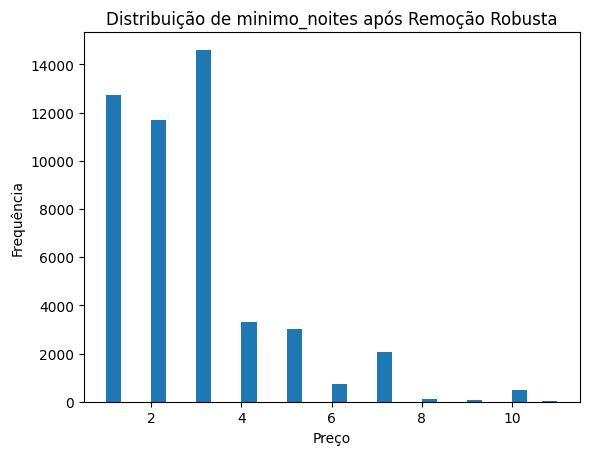

In [61]:
plt.hist(df['minimo_noites_mediana'], bins=30)
plt.title('Distribuição de minimo_noites após Remoção Robusta')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

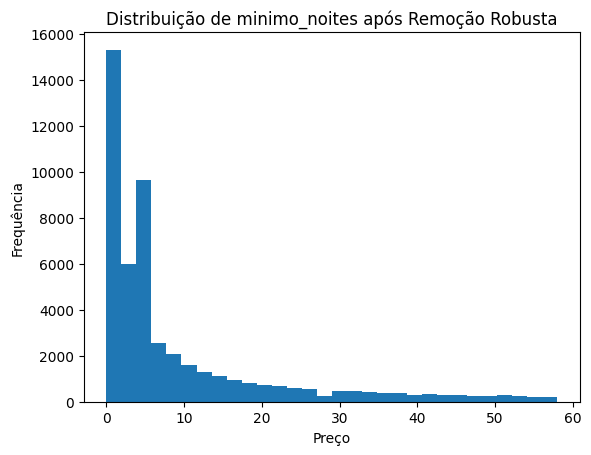

In [62]:
plt.hist(df['numero_de_reviews_mediana'], bins=30)
plt.title('Distribuição de minimo_noites após Remoção Robusta')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

# RELACIONAR AS VARIÁVEIS

Relação entre preço e bairro_group

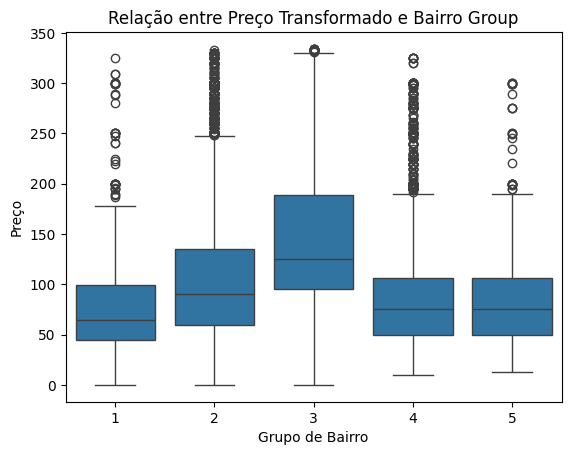

In [63]:
# Relação entre preço e bairro_group
# 1 - Bronx
# 2 - Brooklin
# 3 - Manhattan
# 4 - Queens
# 5 - Staten Island

sns.boxplot(x='bairro_group_encoded', y='price_mediana', data=df)
plt.title('Relação entre Preço Transformado e Bairro Group')
plt.xlabel('Grupo de Bairro')
plt.ylabel('Preço')
plt.show()


 ANÁLISE: O grupo de bairro tem influência no preço dos imóveis, com Manhattan e Brooklyn apresentando preços geralmente mais altos.

Manhattan (3) e Brooklyn (2) tendem a ter preços medianos mais altos em comparação com os outros bairros.
Bronx (1) e Staten Island (5) parecem ter preços medianos mais baixos.
Queens (4) apresenta uma distribuição de preços mais ampla, com uma mediana próxima à do Brooklyn, mas com maior variabilidade

 Relação entre o tipo de quarto e o preço

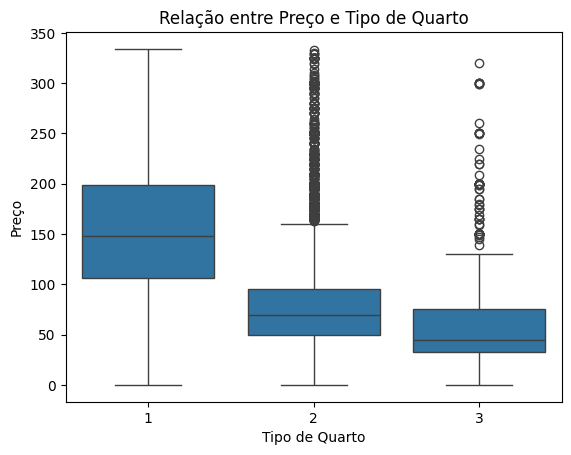

In [64]:
#type_room
#'Entire home/apt': 1,
#'Private room': 2,
#'Shared room': 3,

sns.boxplot(x='room_type_encoded_dummies', y='price_mediana', data=df)
plt.title('Relação entre Preço e Tipo de Quarto')
plt.xlabel('Tipo de Quarto')
plt.ylabel('Preço')
plt.show()

ANÁLISE:

**Quartos compartilhados**: Apresentam os preços mais baixos, indicando uma preferência por viajantes com orçamento limitado ou que buscam interação social.

**Quartos privados**: Oferecem um equilíbrio entre privacidade e custo, com preços intermediários em comparação com as outras opções.

**Apartamentos completos**: São a opção mais cara, proporcionando maior privacidade, espaço e comodidades, geralmente atrativas para famílias ou grupos de viajantes.



**Relação entre Número de Reviews e Preço**

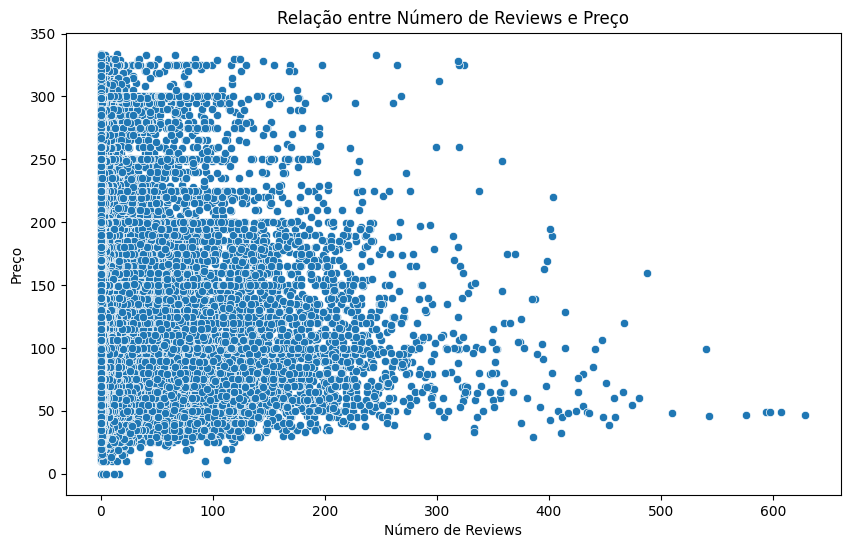

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='numero_de_reviews', y='price_mediana', data=df)
plt.title('Relação entre Número de Reviews e Preço')
plt.xlabel('Número de Reviews')
plt.ylabel('Preço')
plt.show()

ANÁLISE:

Existe uma tendência de que imóveis com preços mais baixos recebam um número maior de reviews. Isso pode indicar que esses imóveis são mais populares entre os viajantes com orçamento limitado, que qualidade do imóvel não veja muito boa ou problemas com o anfitrião.


**Relação entre minino de noites e Preço**

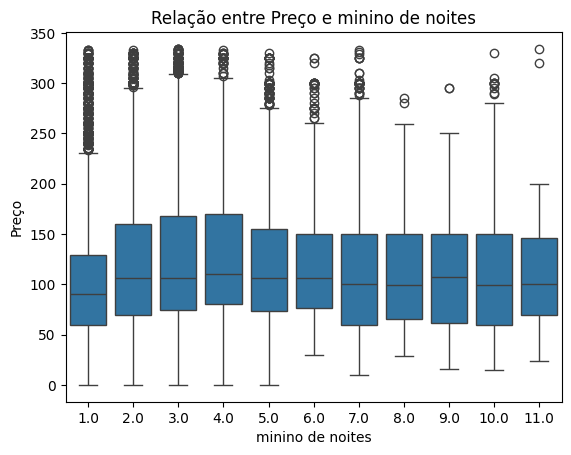

In [66]:
sns.boxplot(x='minimo_noites_mediana', y='price_mediana', data=df)
plt.title('Relação entre Preço e minino de noites')
plt.xlabel('minino de noites')
plt.ylabel('Preço')
plt.show()

ANÁLISE:

Leve tendência de aumento no preço dos imóveis à medida que o mínimo de noites exigido também aumenta.Isso sugere que imóveis com estadias mínimas mais longas podem ter preços mais elevados, possivelmente para compensar a menor rotatividade de hóspedes ou para atender a um público-alvo específico.

Relação entre Disponibilidade e minimo de noites

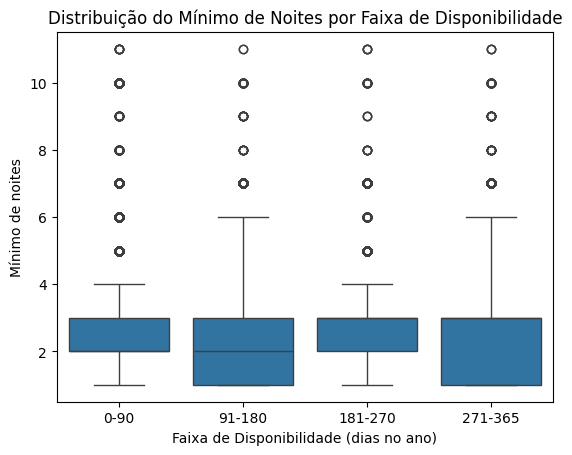

In [67]:
df['faixa_disponibilidade'] = pd.cut(df['disponibilidade_365'], bins=[0, 90, 180, 270, 365], labels=['0-90', '91-180', '181-270', '271-365'])
sns.boxplot(x='faixa_disponibilidade', y='minimo_noites_mediana', data=df)
plt.title('Distribuição do Mínimo de Noites por Faixa de Disponibilidade')
plt.xlabel('Faixa de Disponibilidade (dias no ano)')
plt.ylabel('Mínimo de noites')
plt.show()

ANÁLISE:

Existe uma leve tendência de que imóveis com menor disponibilidade (faixas '0-90' e '91-180') tendam a ter um mínimo de noites mais alto.

**Relação entre Número de Imóveis do Proprietário e Preço**

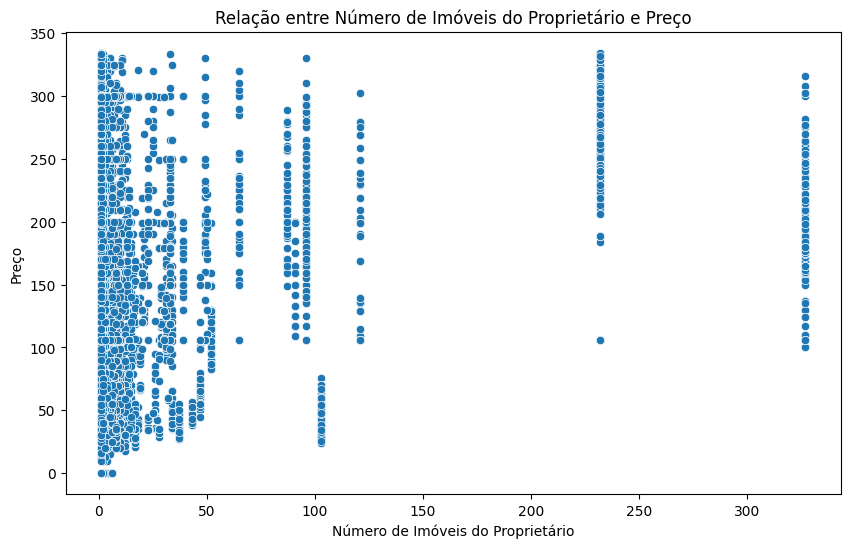

In [68]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='calculado_host_listings_count', y='price_mediana', data=df)
plt.title('Relação entre Número de Imóveis do Proprietário e Preço')
plt.xlabel('Número de Imóveis do Proprietário')
plt.ylabel('Preço')
plt.show()

ANÁLISE:

Existe uma leve tendência positiva entre o número de imóveis do proprietário e o preço mediano dos imóveis. Em geral, proprietários com mais imóveis anunciados tendem a ter imóveis com preços mais altos. Mas essa relação não é muito forte.

Relação entre bairro e tipo de imovel e preço

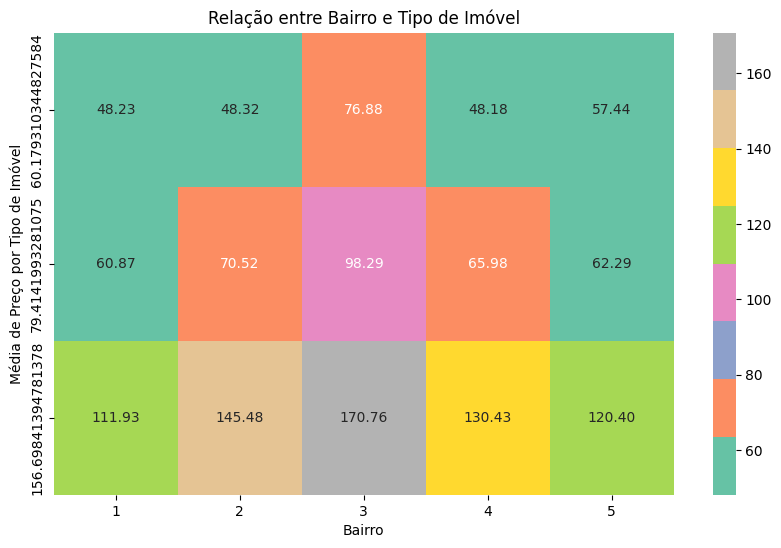

In [69]:
# tabela dinamica
pivot_table = df.pivot_table(
    values='price_mediana',
    index='media_preco_tipo_quarto',
    columns='bairro_group_encoded',
    aggfunc='mean' #
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap="Set2", annot=True, fmt=".2f")
plt.title('Relação entre Bairro e Tipo de Imóvel')
plt.xlabel('Bairro')
plt.ylabel('Média de Preço por Tipo de Imóvel')
plt.show()

 Clara tendência de que os bairros de Manhattan, Brooklyn e Queens apresentem os preços mais elevados para aluguel de imóveis.
 Isso ocorre por que são os bairros de maior pretigio e riqueza cultura de acordo com pesquisas.

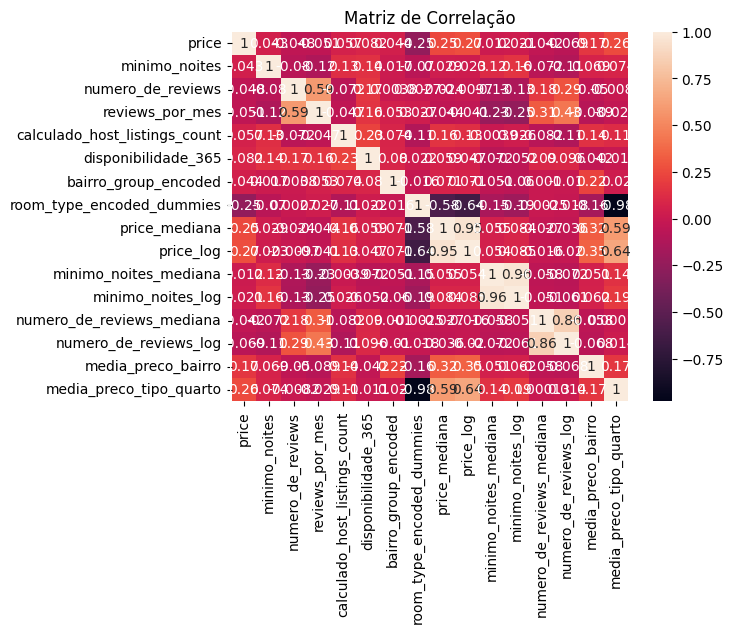

,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,bairro_group_encoded,room_type_encoded_dummies,price_mediana,price_log,minimo_noites_mediana,minimo_noites_log,numero_de_reviews_mediana,numero_de_reviews_log,media_preco_bairro,media_preco_tipo_quarto
count,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.00000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000
mean,152.720763,7.030085,23.274758,1.090928,7.144005,112.776169,2.675359,1.50405,119.120546,4.638883,2.744345,1.229573,9.086125,1.633634,119.120546,119.120546
std,240.156625,20.510741,44.550991,1.597294,32.952855,131.618692,0.735817,0.54538,66.131276,0.558941,1.730523,0.415779,12.604831,1.184087,21.300100,39.193841
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,0.000000,0.000000,1.000000,0.693147,0.000000,0.000000,77.916590,60.179310
25%,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,2.000000,1.00000,69.000000,4.248495,1.000000,0.693147,1.000000,0.693147,105.707755,79.414199
50%,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000,3.000000,1.00000,106.000000,4.672829,3.000000,1.386294,5.000000,1.791759,105.707755,156.698414
75%,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000,3.000000,2.00000,150.000000,5.017280,3.000000,1.386294,11.000000,2.484907,141.978025,156.698414
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,5.000000,3.00000,334.000000,5.814131,11.000000,2.484907,58.000000,4.077537,141.978025,156.698414


In [70]:
# Selecionar apenas colunas numéricas para calcular a correlação
numerical_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numerical_cols].corr()

sns.heatmap(correlation_matrix, annot=True)
plt.title('Matriz de Correlação')
plt.show()
df.describe()

Analisando as Correlações:

- price_mediana (Preço Mediano):
Correlação positiva moderada com media_preco_bairro e media_preco_tipo_quarto.

Correlação positiva com room_type_encoded_dummies (tipo de quarto), indicando que o tipo de quarto tem influência no preço.

- minimo_noites_mediana (Mínimo de Noites Mediano): Correlação positiva fraca com price_mediana, sugerindo que imóveis com mínimo de noites mais alto podem ter preços ligeiramente mais altos.

- numero_de_reviews_mediana (Número de Reviews Mediano): Correlação fraca com minimo_noites_mediana.

Correlação fraca com calculado_host_listings_count (número de imóveis do proprietário).

- calculado_host_listings_count (Número de Imóveis do Proprietário):

Correlação positiva fraca com disponibilidade_365.


# Modelo de ML - Previsão

O problema que estamos resolvendo é de regressão. O objetivo é prever o preço do aluguel de um imóvel com base nas suas características.



Selecionar as features:

As features foram selecionadas com base em sua relevância para a previsão do preço do imóvel e sua disponibilidade no dataset. As seguintes features foram utilizadas:

- bairro_group_encoded: O grupo de bairros é uma feature importante, pois o preço dos imóveis varia significativamente entre os bairros.

- room_type_encoded_dummies: O tipo de quarto é outra feature importante, pois o preço dos imóveis varia de acordo com o tipo de acomodação.

- minimo_noites_mediana: O número mínimo de noites pode influenciar o preço, pois imóveis com mínimo de noites mais alto podem ter preços mais altos.

- numero_de_reviews_mediana: O número de reviews pode indicar a popularidade do imóvel e influenciar o preço.

- disponibilidade_365: A disponibilidade do imóvel ao longo do ano pode influenciar o preço.

- media_preco_bairro: A média de preço por bairro foi incluída como uma feature para capturar a influência do bairro no preço do imóvel.

- media_preco_tipo_quarto: A média de preço por tipo de quarto foi incluída como uma feature para capturar a influência do tipo de quarto no preço do imóvel.


In [71]:
# Atualizar features
features = ['bairro_group_encoded', 'room_type_encoded_dummies', 'minimo_noites_mediana', 'numero_de_reviews_mediana','disponibilidade_365','media_preco_tipo_quarto','media_preco_bairro']
X = df[features]
y = df['price_mediana']

Dividir os dados em treino e teste

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Testando outros modelos

In [73]:
modelos = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'Ridge': Ridge(),
    'BayesianRidge': BayesianRidge(),
    'GradientBoostingRegressor': GradientBoostingRegressor()
}

In [74]:
modelo_rmse = []
modelo_r2 = []
modelo_nomes = []

for nome, modelo in modelos.items():
    fit_modelo = modelo.fit(X_train, y_train)
    predicao = fit_modelo.predict(X_test)

    modelo_r2.append(r2_score(y_test, predicao))
    modelo_rmse.append(np.sqrt(mean_squared_error(y_test, predicao)))
    modelo_nomes.append(nome)

    resultado_final = pd.DataFrame([modelo_nomes, modelo_r2, modelo_rmse]).T
    resultado_final = resultado_final.rename(columns={0:'Modelo', 1: 'R2', 2:'RMSE'}).sort_values(by = 'RMSE')

resultado_final

,Modelo,R2,RMSE
6,GradientBoostingRegressor,0.418607,50.227294
4,Ridge,0.40624,50.758697
0,LinearRegression,0.40624,50.7587
5,BayesianRidge,0.406178,50.761319
2,ElasticNet,0.406076,50.765676
3,SVR,0.374771,52.086412
1,RandomForestRegressor,0.326734,54.050299


# MODELO:
O modelo que melhor se aproximou dos dados foi o GradientBoostingRegressor.

Prós:
Alta precisão em tarefas de regressão.
Robusto a outliers e dados ruidosos.
Capaz de capturar relações complexas entre as variáveis.

Contras:
Pode ser mais complexo de ajustar e interpretar do que modelos lineares.
Pode levar mais tempo para treinar, especialmente com grandes conjuntos de dados.
Pode ser propenso ao overfitting se não for devidamente regularizado.


In [75]:
# Atribuir o GradientBoostingRegressor como modelo pois teve melhor resultado
model = GradientBoostingRegressor()
model.fit(X, y)

GradientBoostingRegressor()

A escolha de métricas considerou **precisão estatística** e **impacto no negócio**:  

```python
# Cálculo das principais métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
```

| Métrica | Valor | O que significa? |  
|---------|-------|------------------|  
| RMSE | ${rmse:.2f} | Erro médio com peso maior para previsões muito erradas |  
| MAE | ${mae:.2f} | Erro médio absoluto em dólares |  
| R² | {r2:.2f} | % da variação de preços explicada pelo modelo |  

**Próximos passos**: Melhorar R² para >0.6 com feature engineering (ex: distância a pontos turísticos).


In [76]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'R²: {r2}')
print(f'RMSE: {rmse}')

R²: 0.4231805205621314
RMSE: 50.0293484493838


In [77]:
# Previsões nos dados de teste
y_pred = model.predict(X_test)

# Calcular o MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Erro Absoluto Médio (MAE): ${mae:.2f}")

# Comparar com a média de preços
mean_price = y_test.mean()
print(f"MAE representa {mae/mean_price*100:.1f}% do preço médio (${mean_price:.2f}/noite)")

Erro Absoluto Médio (MAE): $37.28
MAE representa 31.3% do preço médio ($119.04/noite)


 ## 📉 Avaliação do Modelo
 | Métrica  | Valor  | Interpretação  |
 |----------|--------|----------------|
 | **MAE**  | $37.28 | Erro médio absoluto: o modelo erra ±$37.28 por noite (31.3% do preço médio) |
 | **R²**   | 0.42 | Explica 42% da variação nos preços - espaço para melhorias nas features |
 | **RMSE** | $50.03 | Penaliza mais erros grandes (previsões muito acima/abaixo) |
 

Criar um DataFrame com as variáveis

In [78]:
bairros = df['bairro_group_encoded'].unique()
tipos_quarto = df['room_type_encoded_dummies'].unique()
num_reviews_med = df['numero_de_reviews_mediana'].median()
min_noites_med = df['minimo_noites_mediana'].median()
disponibilidade = df['disponibilidade_365'].median()
med_preco_bairro = df['media_preco_bairro'].median()
med_preco_tipo_quarto = df['media_preco_tipo_quarto'].median()
data = [[bairro, tipo_quarto, num_reviews_med, min_noites_med, disponibilidade, med_preco_bairro, med_preco_tipo_quarto]
        for bairro in bairros
        for tipo_quarto in tipos_quarto]

prev_valor_df = pd.DataFrame(data, columns=['bairro_group_encoded', 'room_type_encoded_dummies', 'numero_de_reviews_mediana', 'minimo_noites_mediana', 'disponibilidade_365', 'media_preco_tipo_quarto','media_preco_bairro'])


Utilizar o modelo para prever os preços

In [79]:
prev_valor_df['price_pred'] = model.predict(prev_valor_df[['bairro_group_encoded', 'room_type_encoded_dummies', 'minimo_noites_mediana', 'numero_de_reviews_mediana', 'disponibilidade_365', 'media_preco_tipo_quarto','media_preco_bairro']])

Ordenar o DataFrame pelos preços previstos

In [80]:
prev_valor_df = prev_valor_df.sort_values('price_pred', ascending=False)
print(prev_valor_df)

    bairro_group_encoded  room_type_encoded_dummies  \
0                      3                          1   
6                      4                          1   
3                      2                          1   
12                     1                          1   
9                      5                          1   
4                      2                          2   
1                      3                          2   
7                      4                          2   
13                     1                          2   
10                     5                          2   
2                      3                          3   
5                      2                          3   
8                      4                          3   
14                     1                          3   
11                     5                          3   

    numero_de_reviews_mediana  minimo_noites_mediana  disponibilidade_365  \
0                         5.0             

Visualizar os resultados

<Axes: xlabel='media_preco_bairro', ylabel='price_pred'>

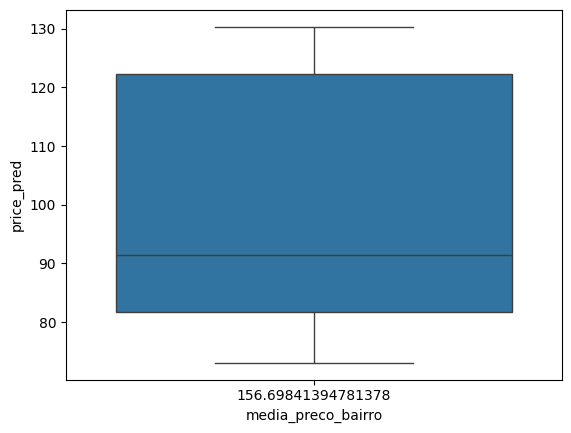

In [81]:
sns.boxplot(x='media_preco_bairro', y='price_pred', data=prev_valor_df)

<Axes: xlabel='room_type_encoded_dummies', ylabel='price_pred'>

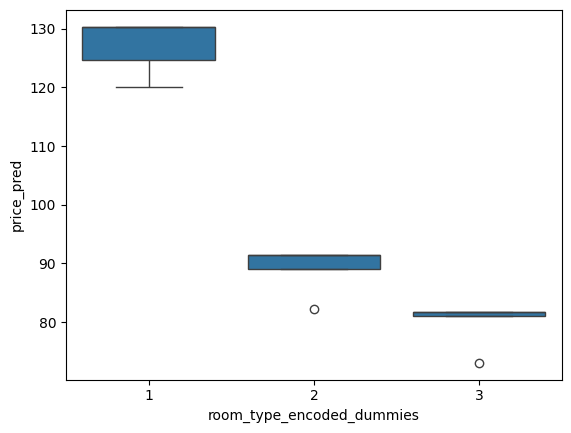

In [82]:
sns.boxplot(x='room_type_encoded_dummies', y='price_pred', data=prev_valor_df)

## Melhores lugares para investir/alugar

In [83]:
# Exibe as 5 primeiras linhas para identificar os melhores lugares para investir/alugar
prev_valor_df = prev_valor_df.sort_values('price_pred', ascending=False)
print(prev_valor_df.head())

    bairro_group_encoded  room_type_encoded_dummies  \
0                      3                          1   
6                      4                          1   
3                      2                          1   
12                     1                          1   
9                      5                          1   

    numero_de_reviews_mediana  minimo_noites_mediana  disponibilidade_365  \
0                         5.0                    3.0                 45.0   
6                         5.0                    3.0                 45.0   
3                         5.0                    3.0                 45.0   
12                        5.0                    3.0                 45.0   
9                         5.0                    3.0                 45.0   

    media_preco_tipo_quarto  media_preco_bairro  price_pred  
0                105.707755          156.698414  130.304021  
6                105.707755          156.698414  130.304021  
3                105

O resultado mostra que os apartamentos inteiros(Entire home/apt) tem os maiores preços previstos em todos os grupos de bairros.
O bairro tem um impacto significativo no preço.
Staten Island, Queens e Manhattan tendo os preços previstos mais altos.

Levando em considerção pesquisas externas Manhattan é o principal distrito da cidade de Nova York. Localizado no centro da cidade onde se encontra arranha-céus, pontos turísticos conhecidos e muitos importantes restaurantes e bares.

Resumindo um apartamento em Manhattan seria o melhor lugar para investir.


# Número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?



In [84]:
#Coeficientes do Modelo
for feature, importance in zip(features, model.feature_importances_):
    print(f'{feature}: {importance}')

bairro_group_encoded: 0.0008001645564409534
room_type_encoded_dummies: 0.4612178398760665
minimo_noites_mediana: 0.01191978345891363
numero_de_reviews_mediana: 0.009890220112390715
disponibilidade_365: 0.027746756034150284
media_preco_tipo_quarto: 0.3668675520508362
media_preco_bairro: 0.12155768391120167


Número mínimo de noites (minimo_noites_mediana): Interfere no preço com baixa influência.

Disponibilidade ao longo do ano (disponibilidade_365): Interfere no preço com moderada influência.



# Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Técnicas de PNL, tokenização e contagem de frequência do nome do local(group_bairro)


In [85]:
bairro_mapping = {
    1: 'Bronx',
    2: 'Brooklyn',
    3: 'Manhattan',
    4: 'Queens',
    5: 'Staten Island'
}

#Selecionar os top 20% dos locais com maior valor previsto
top_locais = prev_valor_df.head(int(len(prev_valor_df) * 0.2))

# Extrair os nomes dos locais
nomes_top_locais = nomes_top_locais = [bairro_mapping[bairro] for bairro in top_locais['bairro_group_encoded'].tolist()]

In [86]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('portuguese'))

# Conjunto de nomes de grupo de bairros
nomes_bairros = {'Staten Island', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens'}

todos_tokens = []
for nome in nomes_top_locais:
    if nome in nomes_bairros:
        todos_tokens.append(nome)
    else:
        tokens = word_tokenize(nome)
        tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
        todos_tokens.extend(tokens)

# Imprimir a lista de tokens
print(todos_tokens)

['Manhattan', 'Queens', 'Brooklyn']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


A saída da análise de frequência indica que 'Manhattan', 'Queens', 'Brooklyn' são os nomes de bairro mais frequente entre os locais de alto valor, sugerindo uma forte associação entre esse bairro e preços mais altos.

# Sugestão de preço par as seguintes carateristicas:

In [87]:
#dicionario de caracteristicas
apartamento = {
        'id': 2595,
        'nome': 'Skylit Midtown Castle',
        'host_id': 2845,
        'host_name': 'Jennifer',
        'bairro_group': 'Manhattan',
        'bairro': 'Midtown',
        'latitude': 40.75362,
        'longitude': -73.98377,
        'room_type': 'Entire home/apt',
        'minimo_noites': 1,
        'numero_de_reviews': 45,
        'ultima_review': '2019-05-21',
        'reviews_por_mes': 0.38,
        'calculado_host_listings_count': 2,
        'disponibilidade_365': 355
    }

In [90]:
def prever_preco_airbnb(apartamento, modelo, df_treino):
    """
    Função para prever preço de imóveis no Airbnb NYC
    
    Parâmetros:
    - apartamento: Dicionário com características do imóvel
    - modelo: Modelo de ML treinado
    - df_treino: DataFrame usado no treino (para calcular medianas)
    
    Retorna:
    - Preço previsto em dólares
    """
    
    # 1. Mapeamentos consistentes com o pré-processamento
    bairro_mapping = {'Manhattan': 3, 'Brooklyn': 2, 'Queens': 4, 
                     'Bronx': 1, 'Staten Island': 5}
    room_type_mapping = {'Entire home/apt': 1, 'Private room': 2, 'Shared room': 3}
    
    # 2. Conversão das features categóricas
    features = {
        'bairro_group_encoded': bairro_mapping[apartamento['bairro_group']],
        'room_type_encoded_dummies': room_type_mapping[apartamento['room_type']],
        'minimo_noites_mediana': apartamento['minimo_noites'],
        'numero_de_reviews_mediana': apartamento['numero_de_reviews'],
        'disponibilidade_365': apartamento['disponibilidade_365'],
        'media_preco_bairro': df_treino['media_preco_bairro'].median(),
        'media_preco_tipo_quarto': df_treino['media_preco_tipo_quarto'].median()
    }
    
    # 3. Criação do DataFrame no formato correto
    colunas = [
        'bairro_group_encoded',
        'room_type_encoded_dummies',
        'minimo_noites_mediana',
        'numero_de_reviews_mediana',
        'disponibilidade_365',
        'media_preco_tipo_quarto',
        'media_preco_bairro'
    ]
    
    X_pred = pd.DataFrame([features])[colunas]
    
    # 4. Predição
    return modelo.predict(X_pred)[0]

# Exemplo de uso:
apartamento_teste = {
    'bairro_group': 'Manhattan',
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'disponibilidade_365': 355
}

preco = prever_preco_airbnb(apartamento_teste, model, df)
print(f"Preço previsto: ${preco:.2f}/noite")

Preço previsto: $150.49/noite


In [89]:
preco_previsto = model.predict(X_apartamento)[0]
print(f'Sugestão de preço: {preco_previsto}')

NameError: name 'X_apartamento' is not defined

SALVAR ARQUIVO EM .pkl

In [177]:
# Salvar o modelo em um arquivo .pkl
import pickle
with open('modelos/precificacao_rf_v1.pkl', 'wb') as arquivo:
    pickle.dump(model, arquivo)